In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import layers
from keras.utils.vis_utils import plot_model

from sklearn import svm
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

np.random.seed(20221107)

In [2]:
# Load the data
path = "../data/weatherAUS.csv"

# Assign format to the date column
data = pd.read_csv(
    path,
    dtype={
        "Location": "category",
        "WindGustDir": "category",
        "WindDir9am": "category",
        "WindDir3pm": "category",
    },
)

# Convert to datetime format
data["Date"] = pd.to_datetime(data["Date"])

# Drop the rows with missing values
data = data.dropna(
    axis=0,
    subset=[
        "RainTomorrow",
        "RainToday",
        "Location",
        "WindGustDir",
        "WindDir9am",
        "WindDir3pm",
    ],
)

# Replace Yes and No with 1 and 0
data[["RainToday", "RainTomorrow"]] = data[["RainToday", "RainTomorrow"]].replace(
    "Yes", 1
)
data[["RainToday", "RainTomorrow"]] = data[["RainToday", "RainTomorrow"]].replace(
    "No", 0
)

data["year"] = pd.DatetimeIndex(data["Date"]).year
data["month"] = pd.DatetimeIndex(data["Date"]).month

# For float64 columns, replace the missing values with the month median
name = data.columns
for j in name:
    if data[j].dtypes == "float64":
        fillNA = data.groupby(["year", "month"])[j].transform("median")
        ind = data[j].isna()
        data.loc[data[j].isna(), j] = fillNA[ind]
    elif data[j].dtypes == "category":
        # Get the Dummy Variables for the categorical variables
        dummy = pd.get_dummies(data[j], prefix=j)
        data = pd.concat([data, dummy], axis=1)
        del data[j]

del data["year"]
del data["month"]

x = data.iloc[:, 1:]
del x["RainTomorrow"]

# Label
y = data["RainTomorrow"]


# If you want to map the data to (0,1), uncomment the following two lines

Mm = MinMaxScaler()
x = Mm.fit_transform(x)

# If you want to use PCA, uncomment the following two lines
# If you don't use PCA, SVM will consume a long time

pca = PCA(n_components=0.85)
x = pca.fit_transform(x)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4)

Test Accuracy: 0.8332188182038639 
Train Accuracy:  0.8333468057015062


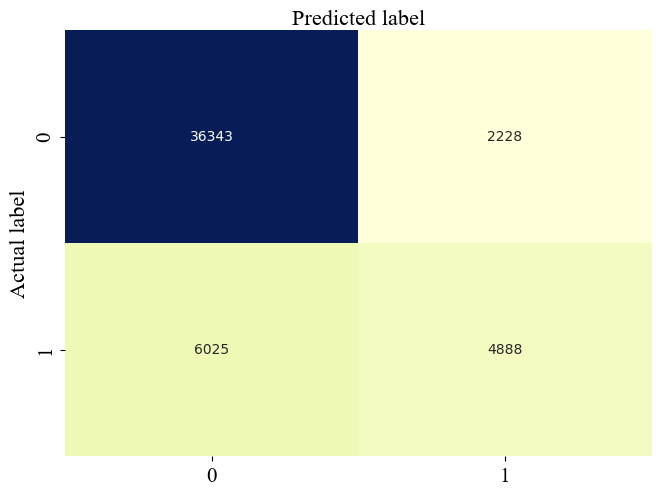

              precision    recall  f1-score   support

 Not Raining       0.86      0.94      0.90     38571
     Raining       0.69      0.45      0.54     10913

    accuracy                           0.83     49484
   macro avg       0.77      0.70      0.72     49484
weighted avg       0.82      0.83      0.82     49484



In [3]:
# Logistic Regression
logreg = LogisticRegression(max_iter=3000)
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)

print(
    "Test Accuracy:",
    metrics.accuracy_score(y_test, y_pred),
    "\nTrain Accuracy: ",
    metrics.accuracy_score(y_train, logreg.predict(x_train)),
)

# Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

font1 = {
    "family": "Times New Roman",
    "weight": "normal",
    "size": 16,
}

class_names = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt="g", cbar=False)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.ylabel("Actual label", font1)
plt.xlabel("Predicted label", font1)


plt.tick_params(labelsize=15)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname("Times New Roman") for label in labels]

plt.savefig("Logit_confusion_matrix.eps", bbox_inches="tight")

plt.show()

# Classification Report
target_names = ["Not Raining", "Raining"]
print(classification_report(y_test, y_pred, target_names=target_names))

Test Accuracy: 0.8326933958451217 
Train Accuracy:  0.832161237302293


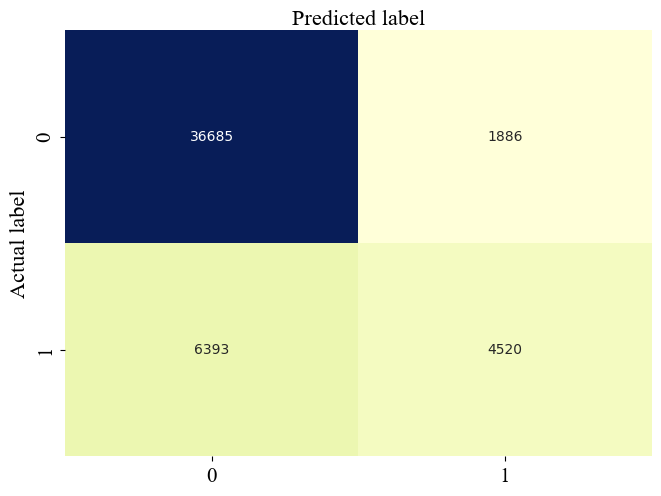

              precision    recall  f1-score   support

 Not Raining       0.85      0.95      0.90     38571
     Raining       0.71      0.41      0.52     10913

    accuracy                           0.83     49484
   macro avg       0.78      0.68      0.71     49484
weighted avg       0.82      0.83      0.82     49484



In [4]:
# SVM
clf = svm.SVC(kernel="linear")

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(
    "Test Accuracy:",
    metrics.accuracy_score(y_test, y_pred),
    "\nTrain Accuracy: ",
    metrics.accuracy_score(y_train, clf.predict(x_train)),
)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt="g", cbar=False)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.ylabel("Actual label", font1)
plt.xlabel("Predicted label", font1)


plt.tick_params(labelsize=15)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname("Times New Roman") for label in labels]

plt.savefig("SVM_confusion_matrix.eps", bbox_inches="tight")

plt.show()

target_names = ["Not Raining", "Raining"]
print(classification_report(y_test, y_pred, target_names=target_names))

Test Accuracy: 0.8437676824832269 
Train Accuracy:  0.8704766523859564


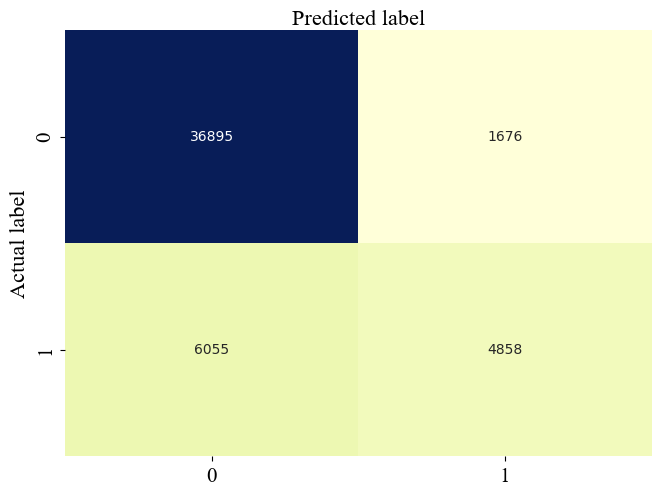

              precision    recall  f1-score   support

 Not Raining       0.86      0.96      0.91     38571
     Raining       0.74      0.45      0.56     10913

    accuracy                           0.84     49484
   macro avg       0.80      0.70      0.73     49484
weighted avg       0.83      0.84      0.83     49484



In [5]:
# SVM with polynomial kernel
clf = svm.SVC(kernel="poly")

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(
    "Test Accuracy:",
    metrics.accuracy_score(y_test, y_pred),
    "\nTrain Accuracy: ",
    metrics.accuracy_score(y_train, clf.predict(x_train)),
)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt="g", cbar=False)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.ylabel("Actual label", font1)
plt.xlabel("Predicted label", font1)


plt.tick_params(labelsize=15)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname("Times New Roman") for label in labels]

plt.savefig("SVM_poly_confusion_matrix.eps", bbox_inches="tight")

plt.show()

target_names = ["Not Raining", "Raining"]
print(classification_report(y_test, y_pred, target_names=target_names))

Test Accuracy: 0.8477891843828308 
Train Accuracy:  0.8671085603427371


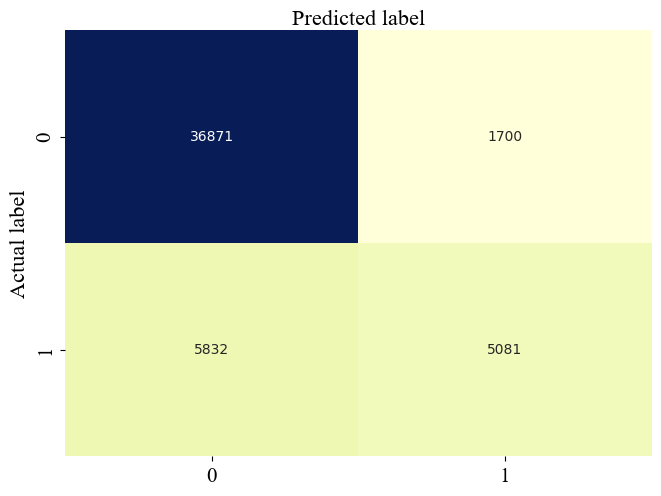

              precision    recall  f1-score   support

 Not Raining       0.86      0.96      0.91     38571
     Raining       0.75      0.47      0.57     10913

    accuracy                           0.85     49484
   macro avg       0.81      0.71      0.74     49484
weighted avg       0.84      0.85      0.83     49484



In [6]:
# SVM with rbf kernel

clf = svm.SVC(kernel="rbf")

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(
    "Test Accuracy:",
    metrics.accuracy_score(y_test, y_pred),
    "\nTrain Accuracy: ",
    metrics.accuracy_score(y_train, clf.predict(x_train)),
)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt="g", cbar=False)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.ylabel("Actual label", font1)
plt.xlabel("Predicted label", font1)


plt.tick_params(labelsize=15)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname("Times New Roman") for label in labels]

plt.savefig("SVM_gauss_confusion_matrix.eps", bbox_inches="tight")

plt.show()

target_names = ["Not Raining", "Raining"]
print(classification_report(y_test, y_pred, target_names=target_names))

Metal device set to: Apple M1 Pro
Epoch 1/50


/var/folders/xp/qjbdwk894vnd1zrb6492fhz00000gn/T/ipykernel_28168/600520522.py:21: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_val = y_train[:7423]
/var/folders/xp/qjbdwk894vnd1zrb6492fhz00000gn/T/ipykernel_28168/600520522.py:22: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  partial_y_train = y_train[7423:]
2022-11-08 22:27:54.499146: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting

261/261 [==============================] - 3s 8ms/step - loss: 0.4137 - accuracy: 0.8161 - val_loss: 0.3708 - val_accuracy: 0.8351
Epoch 2/50
  1/261 [..............................] - ETA: 1s - loss: 0.3936 - accuracy: 0.8320

2022-11-08 22:27:57.037347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


261/261 [==============================] - 2s 7ms/step - loss: 0.3539 - accuracy: 0.8459 - val_loss: 0.3553 - val_accuracy: 0.8453
Epoch 3/50
261/261 [==============================] - 2s 8ms/step - loss: 0.3452 - accuracy: 0.8503 - val_loss: 0.3480 - val_accuracy: 0.8475
Epoch 4/50
261/261 [==============================] - 2s 7ms/step - loss: 0.3385 - accuracy: 0.8533 - val_loss: 0.3428 - val_accuracy: 0.8494
Epoch 5/50
261/261 [==============================] - 2s 7ms/step - loss: 0.3324 - accuracy: 0.8561 - val_loss: 0.3428 - val_accuracy: 0.8483
Epoch 6/50
261/261 [==============================] - 2s 7ms/step - loss: 0.3286 - accuracy: 0.8579 - val_loss: 0.3398 - val_accuracy: 0.8510
Epoch 7/50
261/261 [==============================] - 2s 7ms/step - loss: 0.3252 - accuracy: 0.8590 - val_loss: 0.3377 - val_accuracy: 0.8503
Epoch 8/50
261/261 [==============================] - 2s 7ms/step - loss: 0.3223 - accuracy: 0.8605 - val_loss: 0.3359 - val_accuracy: 0.8548
Epoch 9/50
261/26

2022-11-08 22:29:27.527508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1547/1547 [==============================] - 2s 2ms/step


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Test Accuracy: 0.8587018026028616


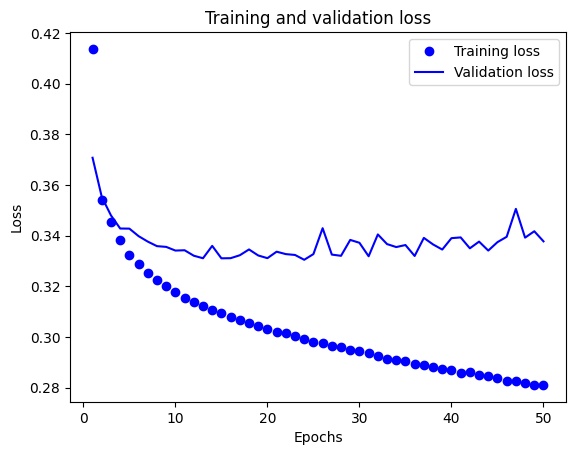

Epoch 1/20
  1/261 [..............................] - ETA: 1:41 - loss: 0.6244 - accuracy: 0.7461

2022-11-08 22:29:30.742718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


261/261 [==============================] - 2s 8ms/step - loss: 0.4084 - accuracy: 0.8184 - val_loss: 0.3674 - val_accuracy: 0.8377
Epoch 2/20
  1/261 [..............................] - ETA: 2s - loss: 0.3343 - accuracy: 0.8477

2022-11-08 22:29:32.736208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


261/261 [==============================] - 2s 7ms/step - loss: 0.3546 - accuracy: 0.8444 - val_loss: 0.3639 - val_accuracy: 0.8385
Epoch 3/20
261/261 [==============================] - 2s 7ms/step - loss: 0.3452 - accuracy: 0.8496 - val_loss: 0.3490 - val_accuracy: 0.8457
Epoch 4/20
261/261 [==============================] - 2s 7ms/step - loss: 0.3381 - accuracy: 0.8533 - val_loss: 0.3503 - val_accuracy: 0.8444
Epoch 5/20
261/261 [==============================] - 2s 7ms/step - loss: 0.3323 - accuracy: 0.8562 - val_loss: 0.3468 - val_accuracy: 0.8478
Epoch 6/20
261/261 [==============================] - 2s 7ms/step - loss: 0.3277 - accuracy: 0.8580 - val_loss: 0.3361 - val_accuracy: 0.8511
Epoch 7/20
261/261 [==============================] - 2s 7ms/step - loss: 0.3247 - accuracy: 0.8598 - val_loss: 0.3374 - val_accuracy: 0.8514
Epoch 8/20
261/261 [==============================] - 2s 7ms/step - loss: 0.3220 - accuracy: 0.8610 - val_loss: 0.3348 - val_accuracy: 0.8507
Epoch 9/20
261/26

2022-11-08 22:30:07.935730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1547/1547 [==============================] - 2s 1ms/step
Test Accuracy: 0.8611268288739795


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


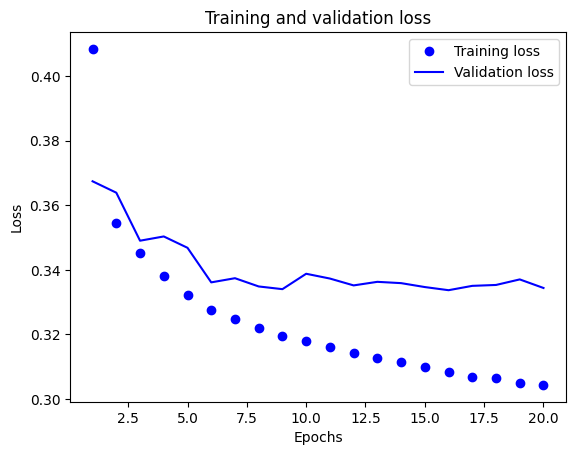

              precision    recall  f1-score   support

 Not Raining       0.88      0.95      0.91     38518
     Raining       0.76      0.55      0.64     10966

    accuracy                           0.86     49484
   macro avg       0.82      0.75      0.78     49484
weighted avg       0.85      0.86      0.85     49484



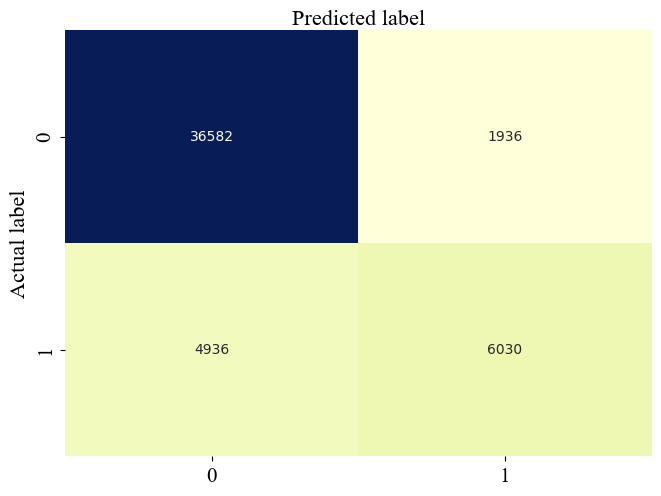

In [7]:
# Neural Network

x = data.iloc[:, 1:]
del x["RainTomorrow"]

# Label
y = data["RainTomorrow"]


# If you want to map the data to (0,1), uncomment the following two lines

Mm = MinMaxScaler()
x = Mm.fit_transform(x)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4)

# Split validation set
x_val = x_train[:7423]
partial_x_train = x_train[7423:]
y_val = y_train[:7423]
partial_y_train = y_train[7423:]

# Build network
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

# Set optimizer, loss function and metrics
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

# Train model
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=50,
    batch_size=256,
    validation_data=(x_val, y_val),
)

# Calculate accuracy
y_pred_proba = model.predict(x_test)

y_pred = list()

for i in y_pred_proba[:, 0]:
    if i > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

print("Test Accuracy:", metrics.accuracy_score(y_test, y_pred))

# Plot training and validation loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("error_50.eps", bbox_inches="tight")
plt.show()

# Retrain model with 20 epochs
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=256,
    validation_data=(x_val, y_val),
)

y_pred_proba = model.predict(x_test)

y_pred = list()

for i in y_pred_proba[:, 0]:
    if i > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

print("Test Accuracy:", metrics.accuracy_score(y_test, y_pred))

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("error_20.eps", bbox_inches="tight")
plt.show()

target_names = ["Not Raining", "Raining"]
print(classification_report(y_test, y_pred, target_names=target_names))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt="g", cbar=False)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.ylabel("Actual label", font1)
plt.xlabel("Predicted label", font1)


plt.tick_params(labelsize=15)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname("Times New Roman") for label in labels]

plt.savefig("FC_confusion_matrix.eps", bbox_inches="tight")

plt.show()

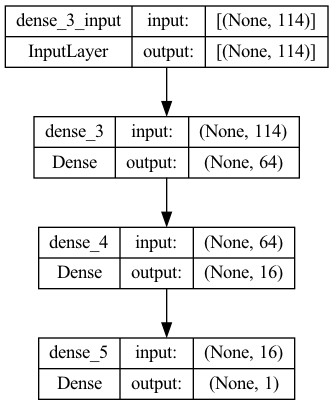

In [8]:
# Plot the Neural Network Structure
plot_model(model, to_file="Network_structure.png", show_shapes=True)